## Embeddings

In our previous example, we operated on high-dimensional bag-of-words vectors with the length of `vocab_size`, and we were explicitly converting from low-dimensional positional representation vectors into sparse one-hot representations. 

<img alt="diagram show how high-dimensional vectors are converted to embedding vectors" src="images/4-embedding-1.png" align="middle" />

The goal of using word embeddings and reducing the dimensionality are:
-  Finding the meaning of words based on their word approximation to other words.  This is done by taken two word vectors and analyzing how often the words in the vectors are used together.  The higher the frequency, the more you can find a correlation and relationship between the words.  
- This process of training the word embedding to find word approximations between words in a given dimension is how we reduce the word representation to low-dimensions.
-  Embedding vectors serve as numeric representations of words and are used as input to other machine learning network layers.
-  The embedding vector becomes the stored lookup table for words in the vocabulary

In this unit, we will continue exploring the **News AG** dataset. To begin, let's load the data and get some definitions from the previous unit.  In addition, we will allocation our training and testing datasets; word vocabulary size; and the category of our word classes: _World_, _Sports_, _Business_ and _Sci/Tech_

In [ ]:
!pip install -r https://raw.githubusercontent.com/MicrosoftDocs/pytorchfundamentals/main/nlp-pytorch/requirements.txt
!pip install torchinfo
!wget -q https://raw.githubusercontent.com/MicrosoftDocs/pytorchfundamentals/main/nlp-pytorch/torchnlp.py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.2/24.2 MB 47.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 32.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 41.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 MB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 804.1/804.1 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 83.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 108.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 93.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 91.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 109.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 KB

> 上面这些包的安装大概需要一分钟的时间

In [1]:
import torch
import torchtext
from torchtext.data import get_tokenizer
import numpy as np
from torchnlp import *
from torchinfo import summary
train_dataset, test_dataset, classes, vocab = load_dataset()


Loading dataset...
Building vocab...


### Dealing with variable sequence size

When working with words, you are going to have text sequences or sentences that are of different lengths.  This can be problematic in training the word embeddings neural network. For consistency in the word embedding and improve training performance, we would have to apply some padding. This can be done using the `torch.nn.functional.pad` on a tokenized dataset. It adds zero values to the empty indices at the end of the vector.

<img alt="diagram show how showing padding" src="images/4-embedding-2.png" align="middle" />


In [2]:
def padify(b):
    # b is the list of tuples of length batch_size
    #   - first element of a tuple = label, 
    #   - second = feature (text sequence)
    # build vectorized sequence
    v = [encode(x[1]) for x in b]
    # first, compute max length of a sequence in this minibatch
    l = max(map(len,v))
    return ( # tuple of two tensors - labels and features
        torch.LongTensor([t[0]-1 for t in b]),
        torch.stack([torch.nn.functional.pad(torch.tensor(t),(0,l-len(t)),mode='constant',value=0) for t in v])
    )

Let's use the first 2 sentences as example to view the text length differences and effects of padding.

In [3]:
first_sentence = train_dataset[0][1]
second_sentence = train_dataset[1][1]

f_tokens = encode(first_sentence)
s_tokens = encode(second_sentence)

print(f'First Sentence in dataset:\n{first_sentence}')
print("f_tokens:", f_tokens)
print("Length:", len(train_dataset[0][1]))
print(f'\nSecond Sentence in dataset:\n{second_sentence}')
print("s_tokens:", s_tokens)
print("Length: ", len(train_dataset[1][1]))

First Sentence in dataset:
Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.
f_tokens: [432, 426, 2, 1606, 14839, 114, 67, 3, 849, 14, 28, 15, 28, 16, 50726, 4, 432, 375, 17, 10, 67508, 7, 52259, 4, 43, 4010, 784, 326, 2]
Length: 144

Second Sentence in dataset:
Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.
s_tokens: [15875, 1073, 855, 1311, 4251, 14, 28, 15, 28, 16, 930, 798, 321, 15875, 99, 4, 27658, 29, 6, 4460, 12, 565, 52791, 9, 80618, 2126, 8, 3, 526, 242, 4, 29, 3891, 82815, 6575, 11, 207, 360, 7, 3, 127, 2]
Length:  266


Let's use the text sequence from the news article headlines in our dataset to change into a tokenize vector.  As you will see, the text sequence have different lengths.  We'll apply padding so all the text sequence will have a fixed length.  This approach is used when you have a large set of text sequences in your dataset.

- The length of the 1st and 2nd sentences displayed have difference lengths.  
- The max length of the dataset tensors is the length of the longest sentence length in the entire dataset.
- The zeros are added to the empty indexes in the tensor.

In [4]:
vocab_size = len(vocab)
labels, features = padify(train_dataset)  
print(f'features: {features}')

print(f'\nlength of first sentence: {len(f_tokens)}')
print(f'length of second sentence: {len(s_tokens)}')
print(f'size of features: {features.size()}')

features: tensor([[  432,   426,     2,  ...,     0,     0,     0],
        [15875,  1073,   855,  ...,     0,     0,     0],
        [   59,     9,   348,  ...,     0,     0,     0],
        ...,
        [ 7736,    63,   665,  ...,     0,     0,     0],
        [   97,    17,    10,  ...,     0,     0,     0],
        [ 2155,   223,  2405,  ...,     0,     0,     0]])

length of first sentence: 29
length of second sentence: 42
size of features: torch.Size([120000, 207])



### What is embedding?

The idea of **embedding** is the process of mapping words into vectors, which reflects the **_semantic meaning of a word_**. The length of its vectors are the embedding dimensions size. We will later discuss how to build meaningful word embeddings, but for now let's just think of embeddings as a way to lower dimensionality of a word vector. 

So, embedding layer would take a word as an input, and produce an output vector of specified `embedding_size`. In a sense, it is very similar to `Linear` layer, but instead of taking one-hot encoded vector, it will be able to take a word number as an input.

By using embedding layer as a first layer in our network, we can switch from bag-or-words to **embedding bag** model, where we first convert each word in our text into corresponding embedding, and then compute some aggregate function over all those embeddings, such as `sum`, `average` or `max`.  

<img alt="Image showing an embedding classifier for five sequence words." src="images/4-embedding-3.png" align="middle" />


Our classifier neural network will start with an embedding layer, then aggregation layer, and a linear classifier on top of it:
- `vocab_size` are the size of the total number of words we have in our vocabulary.
- `embed_dim` are the length of the word dimensions that show relationships between words passed as in the network.
- `num_class` are the number of news categories we are trying to classify (e.g. World, Sports, Business, Sci/Tech) 


In [6]:
class EmbedClassifier(torch.nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):
        super().__init__()
        self.embedding = torch.nn.Embedding(vocab_size, embed_dim)
        self.fc = torch.nn.Linear(embed_dim, num_class)

    def forward(self, x):
        x = self.embedding(x)
        x = torch.mean(x,dim=1)
        return self.fc(x)

### Training embedding classifier

Now we’ll define our training dataloader and use the `collate_fn` to apply the padify function to the datasets as they loaded in each batch.  As a result, the training dataset will be padded.

In [7]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, collate_fn=padify, shuffle=True)

We can train the model using the training function defined in the previous unit to run the embedding network.  The training output serves as a vector lookup store based on the unique index tokens from the vocabulary.

In [9]:
device

device(type='cuda')

In [8]:
net = EmbedClassifier(vocab_size,32,len(classes)).to(device)
train_epoch(net,train_loader, lr=1, epoch_size=25000)

3200: acc=0.64125
6400: acc=0.685
9600: acc=0.7108333333333333
12800: acc=0.727265625
16000: acc=0.7389375
19200: acc=0.7490625
22400: acc=0.7557142857142857


(0.9203356488423704, 0.7589971209213052)

> **Note**: We are only training for 25k records here (less than one full epoch) for the sake of time, but you can continue training, write a function to train for several epochs, and experiment with learning rate parameter to achieve higher accuracy. You should be able to go to the accuracy of about 90%.

### EmbeddingBag Layer and Variable-Length Sequence Representation

In the previous architecture, we needed to pad all sequences to the same length in order to fit them into a minibatch. This is not the most efficient way to represent variable length sequences - another apporach would be to use **offset** vector, which would hold offsets of all sequences stored in one large vector.

<img alt="Image showing an offset sequence representation" src="images/4-embedding-4.png" align="middle" />

> **Note**: On the picture above, we show a sequence of characters, but in our example we are working with sequences of words. However, the general principle of representing sequences with offset vector remains the same.

To work with offset representation, we use PyTorch's `EmbeddingBag` layer. It is similar to `Embedding`, but it takes content vector and offset vector as input, and it also includes averaging layer, which can be `mean`, `sum` or `max`.

Here is modified network that uses `EmbeddingBag`:


In [5]:
class EmbedClassifier(torch.nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):
        super().__init__()
        self.embedding = torch.nn.EmbeddingBag(vocab_size, embed_dim)
        self.fc = torch.nn.Linear(embed_dim, num_class)

    def forward(self, text, off):
        x = self.embedding(text, off)
        return self.fc(x)

> 我们可以发现forward里的参数和net()括号里的参数是需要一致的😀

To prepare the dataset for training, we need to provide a conversion function that will prepare the offset vector:

In [6]:
def offsetify(b):
    # first, compute data tensor from all sequences
    x = [torch.tensor(encode(t[1])) for t in b]
    # now, compute the offsets by accumulating the tensor of sequence lengths
    o = [0] + [len(t) for t in x]
    o = torch.tensor(o[:-1]).cumsum(dim=0)
    return ( 
        torch.LongTensor([t[0]-1 for t in b]), # labels
        torch.cat(x), # text 
        o # offset
    )

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, collate_fn=offsetify, shuffle=True)

The offset vector is calculated by first combining the sentences indices into one tensor sequence, then extracting the starting index location of each sentence in the sequence. For example: 
- The length of the first sentence in our training dataset is 29.  Meaning the first index of the offset will be `0`.
- The length of the second sentence in the dataset is 42.  Meaning the second index of the offset will be `29`, where the first sentence ended. 
- The third index of the offset will be 29 + 42 = `71`, where the 2nd sentence ended.

In [11]:
labels, features, offset = offsetify(train_dataset)  
print(f'offset: {offset}')
print(f'\nlength of first sentence: {len(f_tokens)}')
print(f'length of second sentence: {len(s_tokens)}')
print(f'size of data vector: {features.size()}')
print(f'size of offset vector: {offset.size()}')

offset: tensor([      0,      29,      71,  ..., 5193441, 5193488, 5193569])

length of first sentence: 29
length of second sentence: 42
size of data vector: torch.Size([5193609])
size of offset vector: torch.Size([120000])


> **Note:** that unlike in all previous examples, our network now accepts two parameters: data vector and offset vector, which are of different sizes. Similarly, our data loader also provides us with 3 values instead of 2: both text and offset vectors are provided as features. Therefore, we need to slightly adjust our training function to take care of that:

In [20]:
net = EmbedClassifier(vocab_size,32,len(classes)).to(device)

def train_epoch_emb(net,dataloader,lr=0.01,optimizer=None,loss_fn = torch.nn.CrossEntropyLoss(),epoch_size=None, report_freq=200):
    optimizer = optimizer or torch.optim.Adam(net.parameters(),lr=lr)
    loss_fn = loss_fn.to(device)
    net.train()
    total_loss,acc,count,i = 0,0,0,0
    for labels,text,off in dataloader:
        optimizer.zero_grad()
        labels,text,off = labels.to(device), text.to(device), off.to(device)
        out = net(text, off)
        loss = loss_fn(out,labels) #cross_entropy(out,labels)
        loss.backward()
        optimizer.step()
        total_loss+=loss
        _,predicted = torch.max(out,1)
        acc+=(predicted==labels).sum()
        count+=len(labels)
        i+=1
        if i%report_freq==0:
            print(f"{count}: acc={acc.item()/count}")
        if epoch_size and count>epoch_size:
            break
    return total_loss.item()/count, acc.item()/count


train_epoch_emb(net,train_loader, lr=4, epoch_size=25000)

3200: acc=0.654375
6400: acc=0.69953125
9600: acc=0.7166666666666667
12800: acc=0.726875
16000: acc=0.737625
19200: acc=0.7441666666666666
22400: acc=0.7536607142857142


(23.081501419545745, 0.757597568777991)

In [21]:
train_epoch_emb(net,train_loader, lr=4, epoch_size=30000)

3200: acc=0.844375
6400: acc=0.833125
9600: acc=0.8301041666666666
12800: acc=0.829140625
16000: acc=0.829125
19200: acc=0.829375
22400: acc=0.8314732142857143
25600: acc=0.8321875
28800: acc=0.8329166666666666


(29.38804720815565, 0.8330890191897654)

In [22]:
train_epoch_emb(net,train_loader, lr=4, epoch_size=30000)

3200: acc=0.8625
6400: acc=0.85625
9600: acc=0.8552083333333333
12800: acc=0.8503125
16000: acc=0.8529375
19200: acc=0.8520833333333333
22400: acc=0.8520535714285714
25600: acc=0.8508203125
28800: acc=0.8510416666666667


(34.069302621934966, 0.8513792643923241)

In [23]:
train_epoch_emb(net,train_loader, lr=4, epoch_size=30000)

3200: acc=0.865
6400: acc=0.8678125
9600: acc=0.8677083333333333
12800: acc=0.8678125
16000: acc=0.86625
19200: acc=0.8644791666666667
22400: acc=0.865
25600: acc=0.8638671875
28800: acc=0.8635069444444444


(38.655496235341154, 0.86340618336887)

In [24]:
train_epoch_emb(net,train_loader, lr=2, epoch_size=30000) # 我们可以从上面看到误差越来越大，所以想是学习率的问题产生了过拟合

3200: acc=0.893125
6400: acc=0.88875
9600: acc=0.8828125
12800: acc=0.88328125
16000: acc=0.8834375
19200: acc=0.88265625
22400: acc=0.8806696428571429
25600: acc=0.88125
28800: acc=0.8807638888888889


(19.201765308502132, 0.8800972814498934)

In [25]:
train_epoch_emb(net,train_loader, lr=2, epoch_size=30000) # 这里我们看到可以确保误差是变少的

3200: acc=0.886875
6400: acc=0.88953125
9600: acc=0.8908333333333334
12800: acc=0.89140625
16000: acc=0.891625
19200: acc=0.8919791666666667
22400: acc=0.8936160714285715
25600: acc=0.892890625
28800: acc=0.8930902777777778


(16.960193105343816, 0.8921242004264393)

In [26]:
train_epoch_emb(net,train_loader, lr=1, epoch_size=30000) # 误差再次缩小一半，精确度却没有提升了

3200: acc=0.9090625
6400: acc=0.90578125
9600: acc=0.905
12800: acc=0.904296875
16000: acc=0.9026875
19200: acc=0.8997395833333334
22400: acc=0.8994642857142857
25600: acc=0.8990234375
28800: acc=0.8994097222222223


(8.62700778334888, 0.8995535714285714)

In [30]:
train_epoch_emb(net,train_loader, lr=0.1, epoch_size=30000) # 学习率再后期减小就是正确的决策

3200: acc=0.9253125
6400: acc=0.92953125
9600: acc=0.9285416666666667
12800: acc=0.926640625
16000: acc=0.9265625
19200: acc=0.9264583333333334
22400: acc=0.9252232142857143
25600: acc=0.9249609375
28800: acc=0.9250694444444445


(1.6222955829807435, 0.9249067164179104)

In [35]:
train_epoch_emb(net,train_loader, lr=0.01, epoch_size=30000)

3200: acc=0.9384375
6400: acc=0.92890625
9600: acc=0.928125
12800: acc=0.927890625
16000: acc=0.926875
19200: acc=0.9271875
22400: acc=0.9275446428571429
25600: acc=0.928203125
28800: acc=0.9280208333333333


(0.4447161709067664, 0.9275386460554371)

In [38]:
train_epoch_emb(net,train_loader, lr=0.002, epoch_size=30000)

3200: acc=0.93375
6400: acc=0.9315625
9600: acc=0.9311458333333333
12800: acc=0.93125
16000: acc=0.9306875
19200: acc=0.9306770833333333
22400: acc=0.9309375
25600: acc=0.9307421875
28800: acc=0.9304166666666667


(0.40226238063657715, 0.9308702025586354)


## Semantic Embeddings: Word2Vec

In our previous example, the model embedding layer learnt to map words to vector representation, however, this representation did not have much semantical meaning. It would be nice to learn such vector representation, that similar words or symonims would correspond to vectors that are close to each other in terms of some vector distance (eg. euclidian distance).

To do that, we need to pre-train our embedding model on a large collection of text in a specific way. One of the first ways to train semantic embeddings is called **Word2Vec**.   It helps **_map the probability of a word_**, based on the contexts from texts in the sequence.  It is based on two main architectures that are used to produce a distributed representation of words:

 - **Continuous bag-of-words** (CBoW) — in this architecture, we train the model to predict a word from surrounding context. Given the ngram $(W_{-2},W_{-1},W_0,W_1,W_2)$, the goal of the model is to predict $W_0$ from $(W_{-2},W_{-1},W_1,W_2)$.  For example:  **_"I like my hot dog on a __"_**.  Here the predicted word would be **_"bun"_**.
 - **Continuous skip-gram** is opposite to CBoW. The model uses surrounding window of context words to predict the current word.  For example: you can predict **_dog_** to be more associated with the word **_veterinary_**.

CBoW is faster, while skip-gram is slower, but does a better job of representing infrequent words.

<img alt="Image showing both CBoW and Skip-Gram algorithms to convert words to vectors." src="images/4-embedding-5.png" align="middle" />

Both CBOW and Skip-Grams are “predictive” embeddings, in that they only take local contexts into account. Word2Vec does not take advantage of global context.   

- **GloVe** (Global Vectors) - derives the relationship between words. It determines how often a particular word-pair occurs together in a text by leveraging the idea of co-occurence matrix and uses neural methods to decompose co-occurrence matrix into more expressive and non linear word vectors.
- **FastText** - builds on Word2Vec by learning vector representations for each word and the charachter n-grams found within each word. The values of the representations are then averaged into one vector at each training step. While this adds a lot of additional computation to pre-training, it enables word embeddings to encode sub-word information.
- **Gensim** (Generate Similar) - is an open source NLP Python library that provides a unified interface to build word vectors, corpus, perform topic identification, and other NLP tasks.

FastText and GloVe are other word embeddings techniques that predict the probably of words appearing together.  

In our Word2Vec examples, we'll using pre-trained semantic embeddings, but it is interesting to see how those embeddings can be trained using either FastText, CBoW, or Skip-gram architectures. This exercise goes beyond this module, but those interested can reference Word Embeddings tutorials on Pytorch's website. 

### Genim

The **gensim** framework can be used with Pytorch to train most commonly used embeddings in a few lines of code.  To experiment with word2vec embedding pre-trained on Google News dataset, we can use the **gensim** library. Below we find the words that are most similar to 'neural'

> **Note:** When you first create word vectors, downloading them can take some time!

In [7]:
import gensim.downloader as api
w2v = api.load('word2vec-google-news-300')

> 第一次运行用了8min，因为要下载大概1688M的东西

Let's take a look at words that are similar to 'dog'.

在运行下面语句的时候提示内存已经爆掉了，由于我们是从头运行到这里，可能中间变量太多的问题导致内存不够用了，这里我们单独从上面的`api.load`开始运行就好，第二次运行的时候只用了46s。

> 注：提示下面图片信息的时候，下载过的包由于在硬盘上所以是不受影响的。

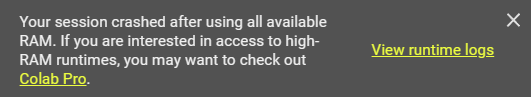

In [3]:
for w,p in w2v.most_similar('dog'):
    print(f"{w} -> {p}")

dogs -> 0.8680489659309387
puppy -> 0.8106428384780884
pit_bull -> 0.780396044254303
pooch -> 0.7627377510070801
cat -> 0.7609456777572632
golden_retriever -> 0.7500902414321899
German_shepherd -> 0.7465174198150635
Rottweiler -> 0.7437614798545837
beagle -> 0.7418621778488159
pup -> 0.740691065788269


In [8]:
w2v.word_vec('dog')[:20]

array([ 0.05126953, -0.02233887, -0.17285156,  0.16113281, -0.08447266,
        0.05737305,  0.05859375, -0.08251953, -0.01538086, -0.06347656,
        0.1796875 , -0.42382812, -0.02258301, -0.16601562, -0.02514648,
        0.10742188, -0.19921875,  0.15917969, -0.1875    , -0.12011719],
      dtype=float32)

In [4]:
for w,p in w2v.most_similar('cat'):
    print(f"{w} -> {p}")

cats -> 0.8099379539489746
dog -> 0.7609456777572632
kitten -> 0.7464985251426697
feline -> 0.7326233983039856
beagle -> 0.7150583267211914
puppy -> 0.7075453996658325
pup -> 0.6934291124343872
pet -> 0.6891531348228455
felines -> 0.6755931377410889
chihuahua -> 0.6709762215614319


In [5]:
for w,p in w2v.most_similar('puppy'):
    print(f"{w} -> {p}")

pup -> 0.8287645578384399
puppies -> 0.8270493745803833
dog -> 0.8106428384780884
kitten -> 0.7805572748184204
pooch -> 0.758628249168396
golden_retriever -> 0.7382912635803223
Pomeranian -> 0.7346876859664917
Sheltie -> 0.7084857821464539
cat -> 0.7075453996658325
Puppy -> 0.7024075984954834


In [6]:
for w,p in w2v.most_similar('human'):
    print(f"{w} -> {p}")

human_beings -> 0.613968014717102
humans -> 0.5917960405349731
impertinent_flamboyant_endearingly -> 0.5868303179740906
employee_Laura_Althouse -> 0.5639358758926392
humankind -> 0.5636305809020996
Human -> 0.5524994134902954
mankind -> 0.5346406698226929
Christine_Gaugler_head -> 0.5272535681724548
humanity -> 0.5262271165847778
sentient_intelligent -> 0.5201493501663208


We can also extract vector embeddings from the word, to be used in training classification model (we'll only show first 20 components of the vector for clarity):

In [7]:
w2v.word_vec('play')[:20]

array([ 0.01226807,  0.06225586,  0.10693359,  0.05810547,  0.23828125,
        0.03686523,  0.05151367, -0.20703125,  0.01989746,  0.10058594,
       -0.03759766, -0.1015625 , -0.15820312, -0.08105469, -0.0390625 ,
       -0.05053711,  0.16015625,  0.2578125 ,  0.10058594, -0.25976562],
      dtype=float32)

The great thing about semantical embeddings is that you can manipulate vector encoding to change the semantics. For example, we can ask to find a word, whose vector representation would be as close as possible to words *king* and *woman*, and as far away from the word *man*:

In [ ]:
w2v.most_similar(positive=['king','woman'],negative=['man'])[0]

('queen', 0.7118192911148071)

## Using Pre-Trained Embeddings in PyTorch

We can modify the example above to pre-populate the matrix in our embedding layer with semantical embeddings, such as Word2Vec. We need to take into account that vocabularies of pre-trained embedding are an addition to the existing text corpus that we already have so they will likely not match. As a result, we will initialize weights for the missing words with random values:

In [8]:
embed_size = len(w2v.get_vector('hello'))
print(f'Embedding size: {embed_size}')

net = EmbedClassifier(vocab_size,embed_size,len(classes))

print('Populating matrix, this will take some time...',end='')
found, not_found = 0,0
for i,w in enumerate(vocab.itos):
    try:
        net.embedding.weight[i].data = torch.tensor(w2v.get_vector(w))
        found+=1
    except:
        net.embedding.weight[i].data = torch.normal(0.0,1.0,(embed_size,))
        not_found+=1

print(f"Done, found {found} words, {not_found} words missing")
net = net.to(device)

Embedding size: 300
Populating matrix, this will take some time...Done, found 41080 words, 54732 words missing


Now let's train our model. Note that the time it takes to train the model is significantly larger than in the previous example, due to larger embedding layer size, and thus much higher number of parameters. Also, because of this, we may need to train our model on more examples if we want to avoid overfitting.

In [9]:
train_epoch_emb(net,train_loader, lr=4, epoch_size=25000)

3200: acc=0.6278125
6400: acc=0.68734375
9600: acc=0.7142708333333333
12800: acc=0.72953125
16000: acc=0.7405
19200: acc=0.7507291666666667
22400: acc=0.7573214285714286


(224.34968809980805, 0.7615563019833653)

In our case we do not see a huge increase in accuracy, which is likely due to the quite different vocalularies. 
To overcome the problem of different vocabularies, we can use one of the following solutions:
* Re-train word2vec model on our vocabulary
* Load our dataset with the vocabulary from the pre-trained word2vec model. Vocabulary used to load the dataset can be specified during loading.

The latter approach seems easier, especially because PyTorch `torchtext` framework contains built-in support for embeddings. 

### GloVe Embeddings

To load our dataset with the vocabulary from a pre-trained word2vec model, we use Glove embeddings. We'll start by instantiating GloVe-based vocabulary in the following manner:

In [10]:
vocab = torchtext.vocab.GloVe(name='6B', dim=50)

.vector_cache/glove.6B.zip: 862MB [02:41, 5.32MB/s]                           
100%|█████████▉| 399999/400000 [00:08<00:00, 49524.09it/s]


> 用时三分钟

Loaded vocabulary has the following basic operations:
* `vocab.stoi` dictionary allows us to convert word into its dictionary index
* `vocab.itos` does the opposite - converts number into word
* `vocab.vectors` is the array of embedding vectors, so to get the embedding of a word we need to use `vocab.vectors[vocab.stoi[s]]`

Here is the example of manipulating embeddings to demonstrate the equation **king-man+woman = queen** (the coefficient was tweak a bit to make it work):

In [11]:
# get the vector corresponding to kind-man+woman
qvec = vocab.vectors[vocab.stoi['king']]-vocab.vectors[vocab.stoi['man']]+1.3*vocab.vectors[vocab.stoi['woman']]
# find the index of the closest embedding vector 
d = torch.sum((vocab.vectors-qvec)**2,dim=1)
min_idx = torch.argmin(d)
# find the corresponding word
vocab.itos[min_idx]

'queen'

In [12]:
# 我们修改一下参数看会得到什么
qvec = vocab.vectors[vocab.stoi['king']]-vocab.vectors[vocab.stoi['man']]+1*vocab.vectors[vocab.stoi['woman']]
d = torch.sum((vocab.vectors-qvec)**2,dim=1)
min_idx = torch.argmin(d)
vocab.itos[min_idx]

'king'

In [13]:
# king man-- woman++ -->queen -->mother
qvec = vocab.vectors[vocab.stoi['king']]-vocab.vectors[vocab.stoi['man']]+2*vocab.vectors[vocab.stoi['woman']]
d = torch.sum((vocab.vectors-qvec)**2,dim=1)
min_idx = torch.argmin(d)
vocab.itos[min_idx]

'mother'

In [14]:
# king man-- woman++ -->queen -->mother -->woman
qvec = vocab.vectors[vocab.stoi['king']]-vocab.vectors[vocab.stoi['man']]+3*vocab.vectors[vocab.stoi['woman']]
d = torch.sum((vocab.vectors-qvec)**2,dim=1)
min_idx = torch.argmin(d)
vocab.itos[min_idx]

'woman'

In [18]:
# king woman++ -->mother
qvec = vocab.vectors[vocab.stoi['king']] + 1*vocab.vectors[vocab.stoi['woman']]
d = torch.sum((vocab.vectors-qvec)**2,dim=1)
min_idx = torch.argmin(d)
vocab.itos[min_idx]

'mother'

To train the classifier using those embeddings, we first need to encode our dataset using GloVe vocabulary:

In [19]:
def offsetify(b):
    # first, compute data tensor from all sequences
    x = [torch.tensor(encode(t[1],voc=vocab)) for t in b] # pass the instance of vocab to encode function!
    # now, compute the offsets by accumulating the tensor of sequence lengths
    o = [0] + [len(t) for t in x]
    o = torch.tensor(o[:-1]).cumsum(dim=0)
    return ( 
        torch.LongTensor([t[0]-1 for t in b]), # labels
        torch.cat(x), # text 
        o
    )

As we have seen above, all vector embeddings are stored in `vocab.vectors` matrix. It makes it super-easy to load those weights into weights of embedding layer using simple copying:

In [20]:
net = EmbedClassifier(len(vocab),len(vocab.vectors[0]),len(classes))
net.embedding.weight.data = vocab.vectors
net = net.to(device)

Now let's train our model and see if we get better results:

In [21]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, collate_fn=offsetify, shuffle=True)
train_epoch_emb(net,train_loader, lr=4, epoch_size=25000)

3200: acc=0.654375
6400: acc=0.6890625
9600: acc=0.7139583333333334
12800: acc=0.724765625
16000: acc=0.737625
19200: acc=0.7423958333333334
22400: acc=0.7494196428571429


(37.06449686100448, 0.7555982085732565)

In [27]:
train_epoch_emb(net,train_loader, lr=0.05, epoch_size=25000)

3200: acc=0.8921875
6400: acc=0.88796875
9600: acc=0.8894791666666667
12800: acc=0.891328125
16000: acc=0.89025
19200: acc=0.8896875
22400: acc=0.8884821428571429


(0.7646954537048145, 0.8876759436980166)

One of the reasons we are not seeing a significant increase in accuracy is due to the fact that some words from our dataset are missing in the pre-trained GloVe vocabulary, and thus they are essentially ignored. To overcome this fact, we can train our own embeddings on our dataset.

## Contextual Embeddings

One key limitation of traditional pretrained embedding representations such as Word2Vec is the problem of word sense and removing ambiguity by making them clear. While pretrained embeddings can capture some of the meaning of words in context, every possible meaning of a word is encoded into the same embedding. This can cause problems in downstream models, since many words such as the word 'play' have different meanings depending on the context they are used in.

For example, the word 'play' in these two different sentences have quite different meaning:
- I went to a **play** at the theatre.
- John wants to **play** with his friends.

The pretrained embeddings above represent both meanings of the word 'play' in the same embedding. To overcome this limitation, we need to build embeddings based on the **language model**, which is trained on a large corpus of text, and *knows* how words can be put together in different contexts. Discussing contextual embeddings is out of scope for this tutorial, but we will come back to them when talking about language models in the next unit.


> 上下文有关的embedding